In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize 

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import sys
from skimage.color import rgb2gray
from tensorflow import keras

2022-10-04 10:48:34.307950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 10:48:34.431717: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-04 10:48:34.857044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/shaun/miniconda3/envs/tf/lib/
2022-10-04 10:48:34.857134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin

In [2]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

NUM_TEST_IMAGES = 10

In [4]:
# get a list of files in each folder
base = r'/home/shaun/data/merged'
img_list = os.listdir(os.path.join(base, '2015_2016/tiles'))
mask_list = os.listdir(os.path.join(base, 'outlines/tiles'))

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

df_images.head(10)

image_id has_mask
0  2015_2016__1178.jpg      yes
1  2015_2016__3864.jpg      yes
2  2015_2016__8164.jpg      yes
3  2015_2016__5881.jpg      yes
4  2015_2016__6310.jpg      yes
5  2015_2016__4945.jpg      yes
6   2015_2016__061.jpg      yes
7  2015_2016__4496.jpg      yes
8  2015_2016__7826.jpg      yes
9  2015_2016__4387.jpg      yes

In [5]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])

# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(7898, 3)
(10, 3)


In [6]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

X_test.shape

(10, 224, 224, 3)

In [7]:
# X_test
selected = ['2015_2016__69.jpg', '2015_2016__73.jpg', '2015_2016__094.jpg',
            '2015_2016__79.jpg', '2015_2016__87.jpg', '2015_2016__097.jpg',
            '2015_2016__104.jpg', '2015_2016__158.jpg', '2015_2016__170.jpg',
            '2015_2016__180.jpg']

# dense_blds = ['rolleston_13824_13312.jpeg', 'rolleston_13824_13824.jpeg', 'rolleston_14336_10752.jpeg',
#               'rolleston_14336_11264.jpeg', 'rolleston_14336_11776.jpeg', 'rolleston_14336_25088.jpeg',
#               'rolleston_14848_10240.jpeg', 'rolleston_14848_11264.jpeg', 'rolleston_15360_1536.jpeg',
#               'rolleston_15360_6656.jpeg']

for i, image_id in enumerate(selected):
    
    path_image = os.path.join(base, '2015_2016/tiles', image_id)
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    # image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_test
    X_test[i] = image
    
X_test.shape

(10, 224, 224, 3)

In [8]:
test_masks = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for i, img in enumerate(selected):
    path_image = os.path.join(base, 'outlines/tiles', img)
    image = imread(path_image)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = rgb2gray(image)
    image = np.expand_dims(image, axis=-1)
    test_masks[i] = image
test_masks.shape

(10, 224, 224, 3)

In [9]:
model = keras.models.load_model('/home/shaun/PHYS_391B/model.h5')

# test_preds = model.predict(X_test)
# test_preds.shape

2022-10-04 10:48:46.567339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 10:48:46.571479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 10:48:46.572091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 10:48:46.573023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
test_preds = model.predict(X_test)
test_preds.shape

2022-10-04 10:48:49.176083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-04 10:48:49.662552: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step


2022-10-04 10:48:50.431943: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(10, 224, 224, 1)

### Now using the fabled Sobel operator:
- The docs for the code is [here](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d)

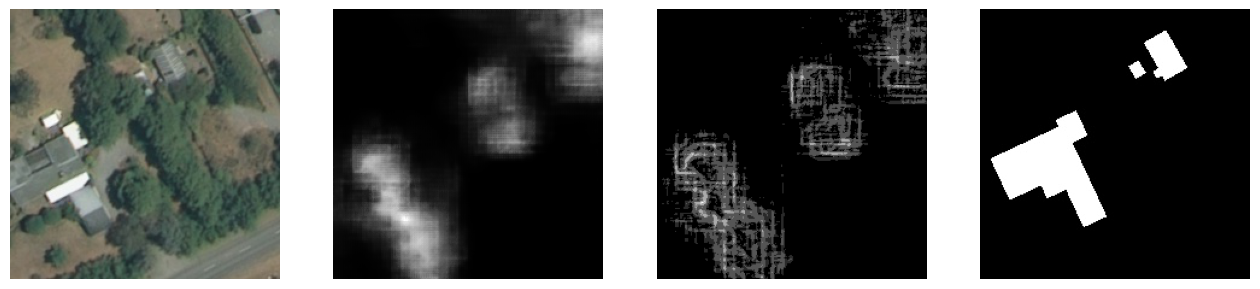

In [11]:
test_img = test_preds[5, :, :, 0] #some random im
specific_mask = test_masks[5, :, :, 0]
specific_sat = X_test[5, :, :]

ddepth=cv2.CV_16S
# plt.imshow(test_img, cmap='gray')

grad_x = cv2.Sobel(test_img, ddepth, 1, 0, ksize=5) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
grad_y = cv2.Sobel(test_img, ddepth, 0, 1, ksize=5) # This is dy

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)


fig, ax = plt.subplots(1, 4, figsize=(16, 14))

ax[0].imshow(specific_sat)
ax[1].imshow(test_img, cmap='gray')
ax[2].imshow(grad, cmap='gray')
ax[3].imshow(specific_mask, cmap='gray')

for i in range(len(ax)):
    ax[i].set_axis_off()

plt.show()

### Let's do a quick and dirty plot of all the predictions:

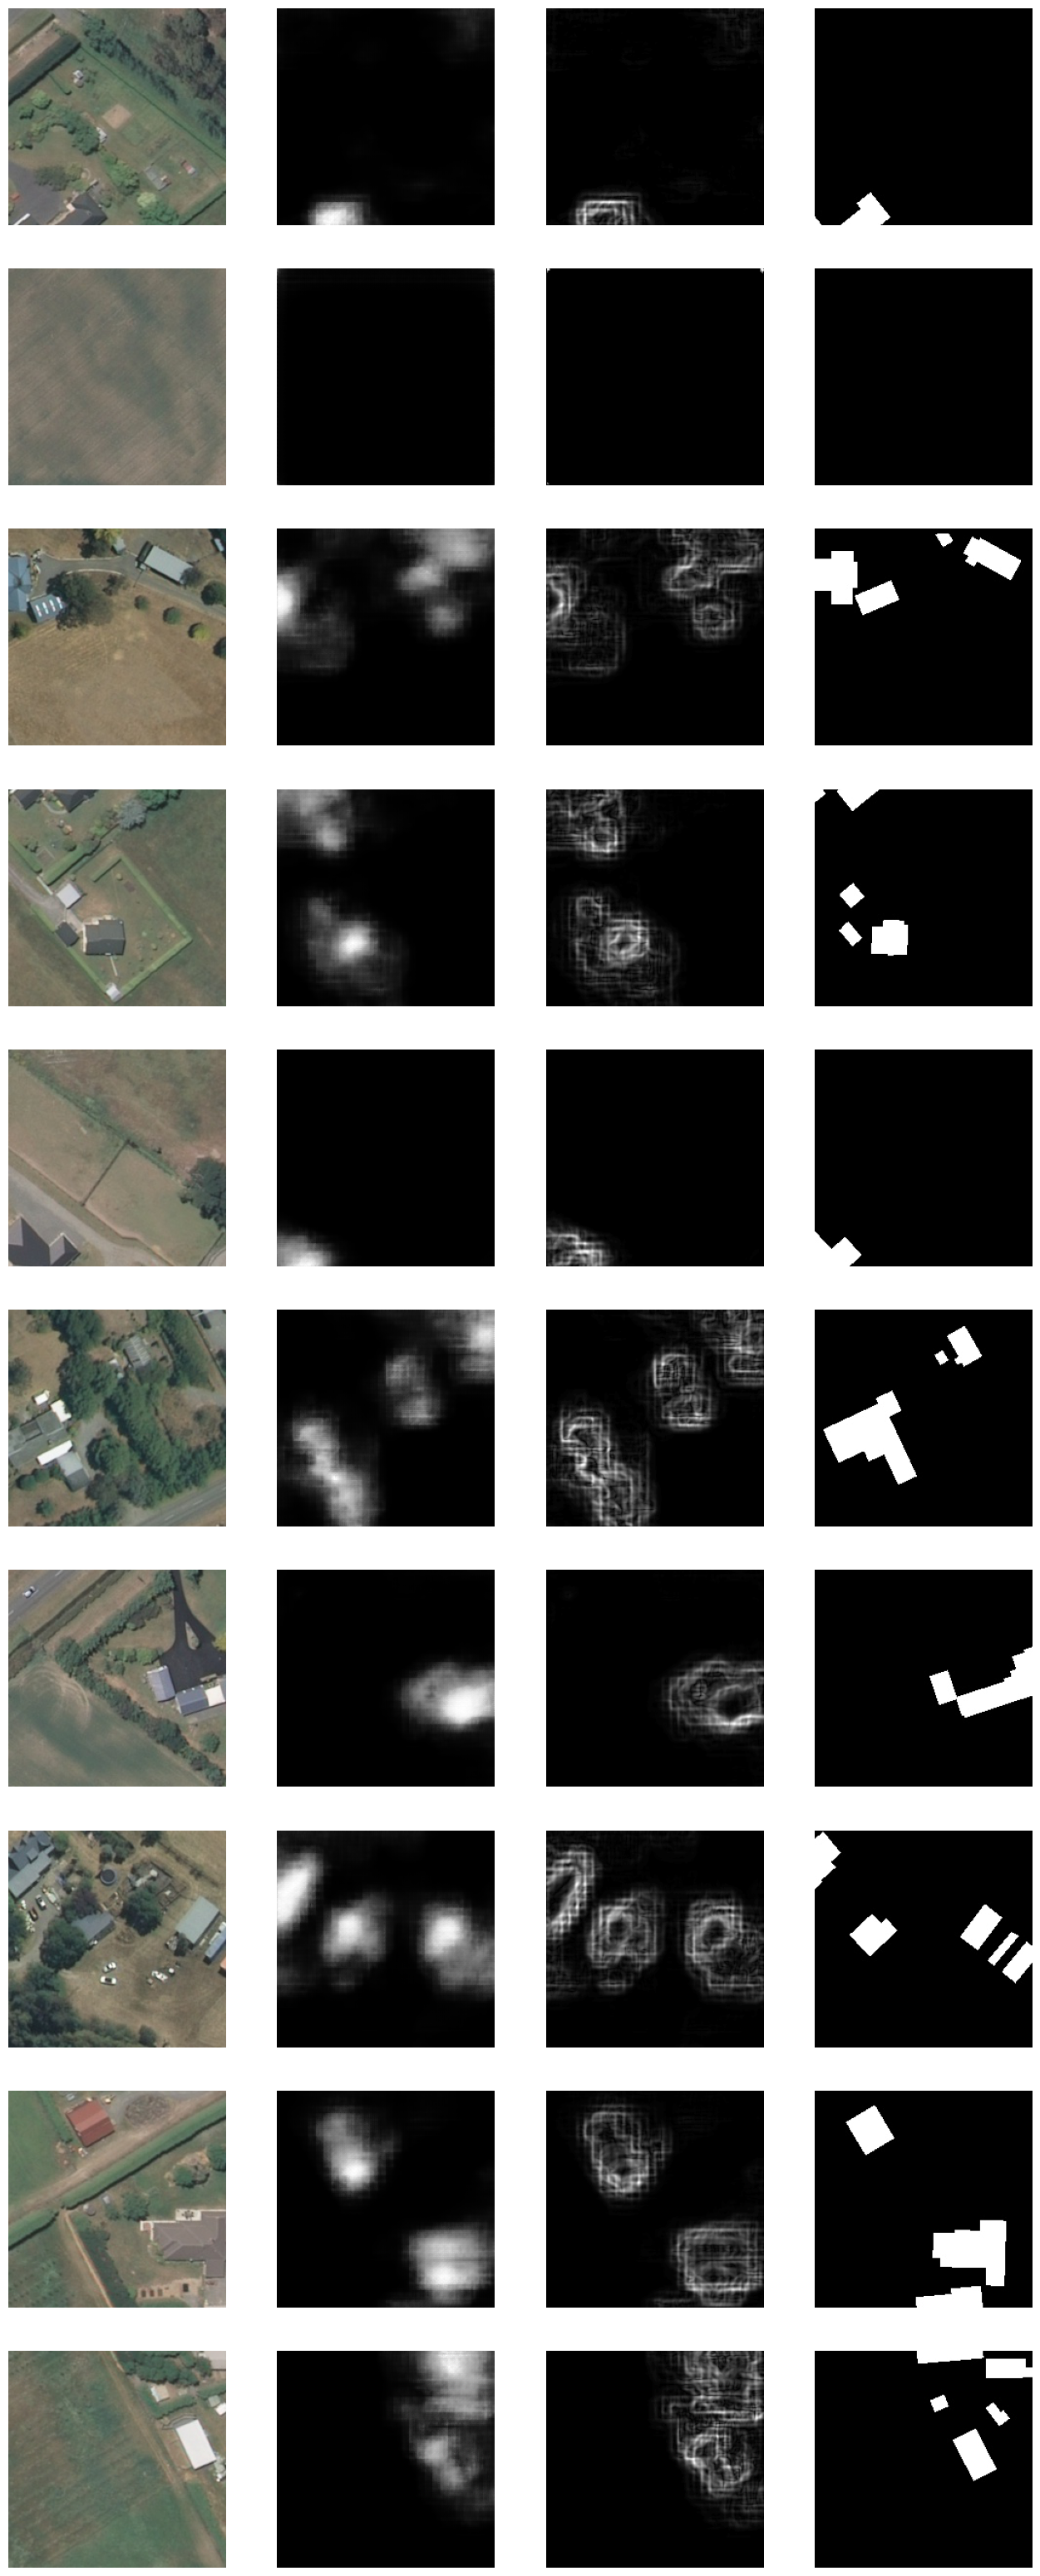

In [24]:
fig, ax = plt.subplots(10, 4, figsize=(16, 40))

for i in range(len(test_preds[:, 0, 0, 0])):

    test_img = test_preds[i, :, :, 0] #some random im
    specific_mask = test_masks[i, :, :, 0]
    specific_sat = X_test[i, :, :]

    ddepth=cv2.CV_16S
    # plt.imshow(test_img, cmap='gray')

    grad_x = cv2.Sobel(test_img, ddepth, 1, 0, ksize=7) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
    grad_y = cv2.Sobel(test_img, ddepth, 0, 1, ksize=7) # This is dy

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

    ax[i][0].imshow(specific_sat)
    ax[i][1].imshow(test_img, cmap='gray')
    ax[i][2].imshow(grad, cmap='gray')
    ax[i][3].imshow(specific_mask, cmap='gray')

    for j in range(0,4):
        ax[i][j].set_axis_off()

plt.show()

In [ ]:
# preds_test_thresh = (test_preds >= 0.31).astype(np.uint8)

### Evaluation of the Sobel operator
- It works really well for strict orientation in the x,y plane, i.e. a square object, but struggles to interpolate diagonals.
- There is an obvious rectangular bias evident in the above outputs. The use of a [Canny](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de) Edge detection kernel should improve this

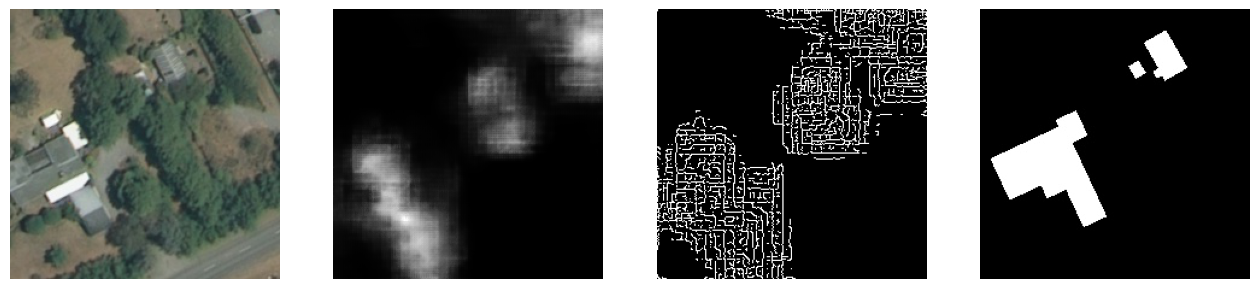

In [29]:
test_img = test_preds[5, :, :, 0] #some random im
specific_mask = test_masks[5, :, :, 0]
specific_sat = X_test[5, :, :]

ddepth=cv2.CV_16S
# plt.imshow(test_img, cmap='gray')
scaled = (test_img*255).astype(np.uint8)
grad = cv2.Canny(scaled,100,110, apertureSize=5)

fig, ax = plt.subplots(1, 4, figsize=(16, 14))

ax[0].imshow(specific_sat)
ax[1].imshow(test_img, cmap='gray')
ax[2].imshow(grad, cmap='gray')
ax[3].imshow(specific_mask, cmap='gray')

for i in range(len(ax)):
    ax[i].set_axis_off()

plt.show()

Frankly, the Canny filter looks much worse than the Sobel filter. \
As an alternative, I am going to test if I can simply apply a lower bounded floor to the sobel filter output \
and see if the edges look better. This is essentially what the canny filter does,\
but it does it prior to applying the sobel operator creating too many peaks.

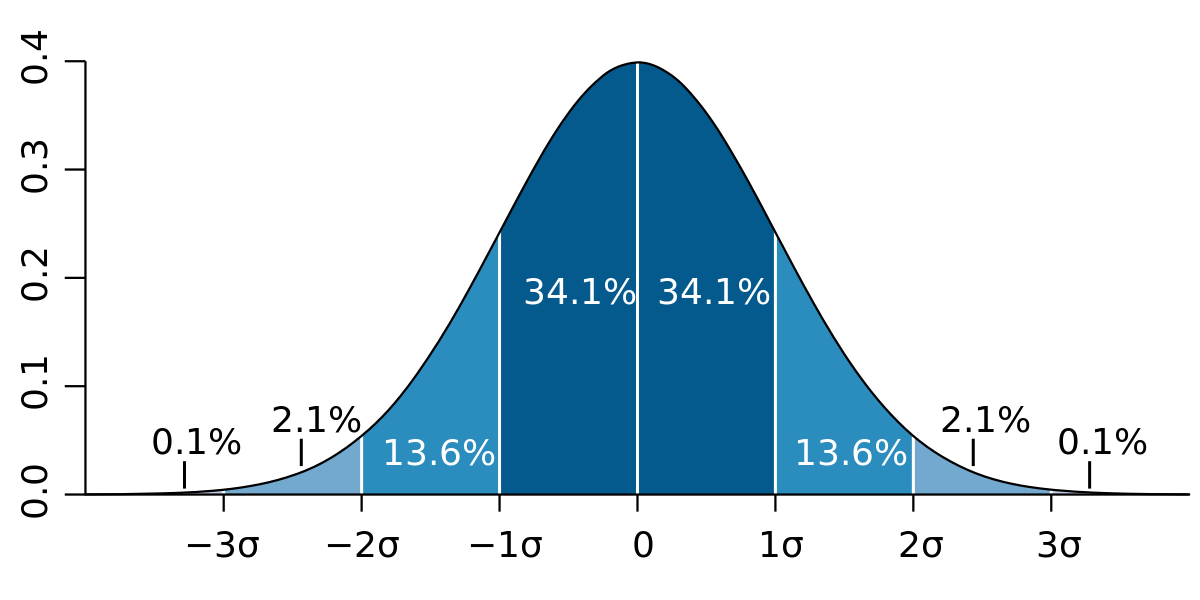

In [32]:
# Show kernel formula image
from IPython.display import Image
Image(r'/home/shaun/PHYS_391B/norm.png')

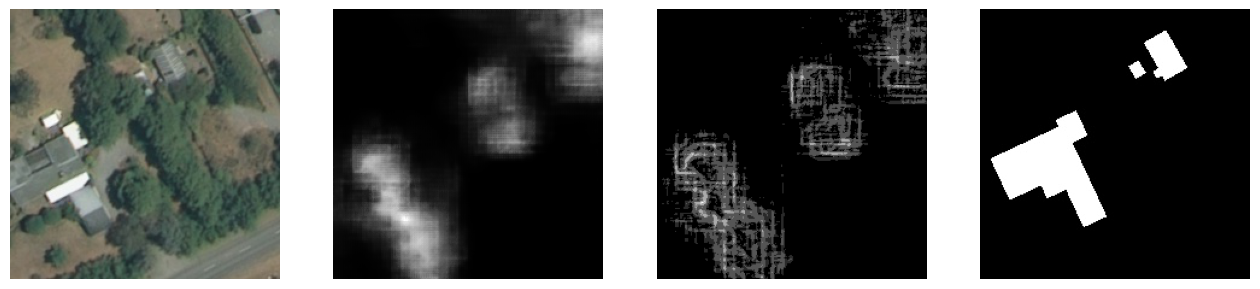

In [30]:
test_img = test_preds[5, :, :, 0] #some random im
specific_mask = test_masks[5, :, :, 0]
specific_sat = X_test[5, :, :]

ddepth=cv2.CV_16S
# plt.imshow(test_img, cmap='gray')

grad_x = cv2.Sobel(test_img, ddepth, 1, 0, ksize=5) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
grad_y = cv2.Sobel(test_img, ddepth, 0, 1, ksize=5) # This is dy

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)


fig, ax = plt.subplots(1, 4, figsize=(16, 14))

ax[0].imshow(specific_sat)
ax[1].imshow(test_img, cmap='gray')
ax[2].imshow(grad, cmap='gray')
ax[3].imshow(specific_mask, cmap='gray')

for i in range(len(ax)):
    ax[i].set_axis_off()

plt.show()

In [33]:
# find std, mean of prediction image:
std = np.std(test_img)
mean = np.mean(test_img)

# now we apply a floor at the -2 sigma level

preds_test_thresh = (test_preds >= mean - 2*std).astype(np.uint8)

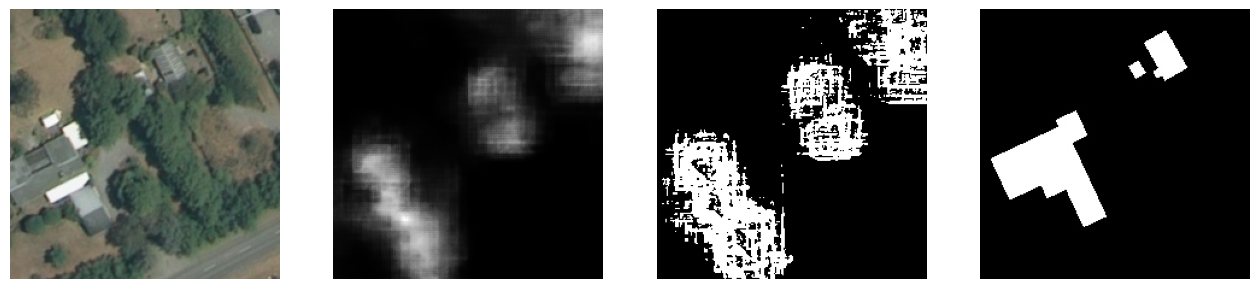

In [44]:
test_img = test_preds[5, :, :, 0] #some random im
specific_mask = test_masks[5, :, :, 0]
specific_sat = X_test[5, :, :]

ddepth=cv2.CV_16S
# plt.imshow(test_img, cmap='gray')

grad_x = cv2.Sobel(test_img, ddepth, 1, 0, ksize=5) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
grad_y = cv2.Sobel(test_img, ddepth, 0, 1, ksize=5) # This is dy

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

grad_thresh = (grad >= mean + 3*std).astype(np.uint8)

fig, ax = plt.subplots(1, 4, figsize=(16, 14))

ax[0].imshow(specific_sat)
ax[1].imshow(test_img, cmap='gray')
ax[2].imshow(grad_thresh, cmap='gray')
ax[3].imshow(specific_mask, cmap='gray')

for i in range(len(ax)):
    ax[i].set_axis_off()

plt.show()

Yeah this didn't work very well. Let us try thresholding the predictions before applying the sobel operator:

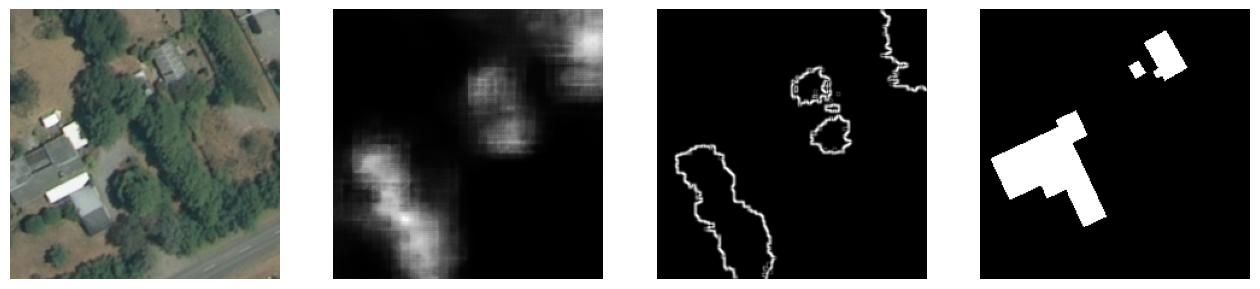

In [51]:
test_img = test_preds[5, :, :, 0] #some random im
specific_mask = test_masks[5, :, :, 0]
specific_sat = X_test[5, :, :]

ddepth=cv2.CV_16S
# plt.imshow(test_img, cmap='gray')

thresh_im = (test_img >= mean + std).astype(np.uint8) # applying the upper std thresh

grad_x = cv2.Sobel(thresh_im, ddepth, 1, 0, ksize=5) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
grad_y = cv2.Sobel(thresh_im, ddepth, 0, 1, ksize=5) # This is dy

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

fig, ax = plt.subplots(1, 4, figsize=(16, 14))

ax[0].imshow(specific_sat)
ax[1].imshow(test_img, cmap='gray')
ax[2].imshow(grad, cmap='gray')
ax[3].imshow(specific_mask, cmap='gray')

for i in range(len(ax)):
    ax[i].set_axis_off()

plt.show()

### Success!!!
This looks much better than the Canny operator and should let us count the individual buildings much more accurately.\
Also, since the basis of this new threshold is just the assumption of a normal distribution, we can apply this empirically to the rest of our images:

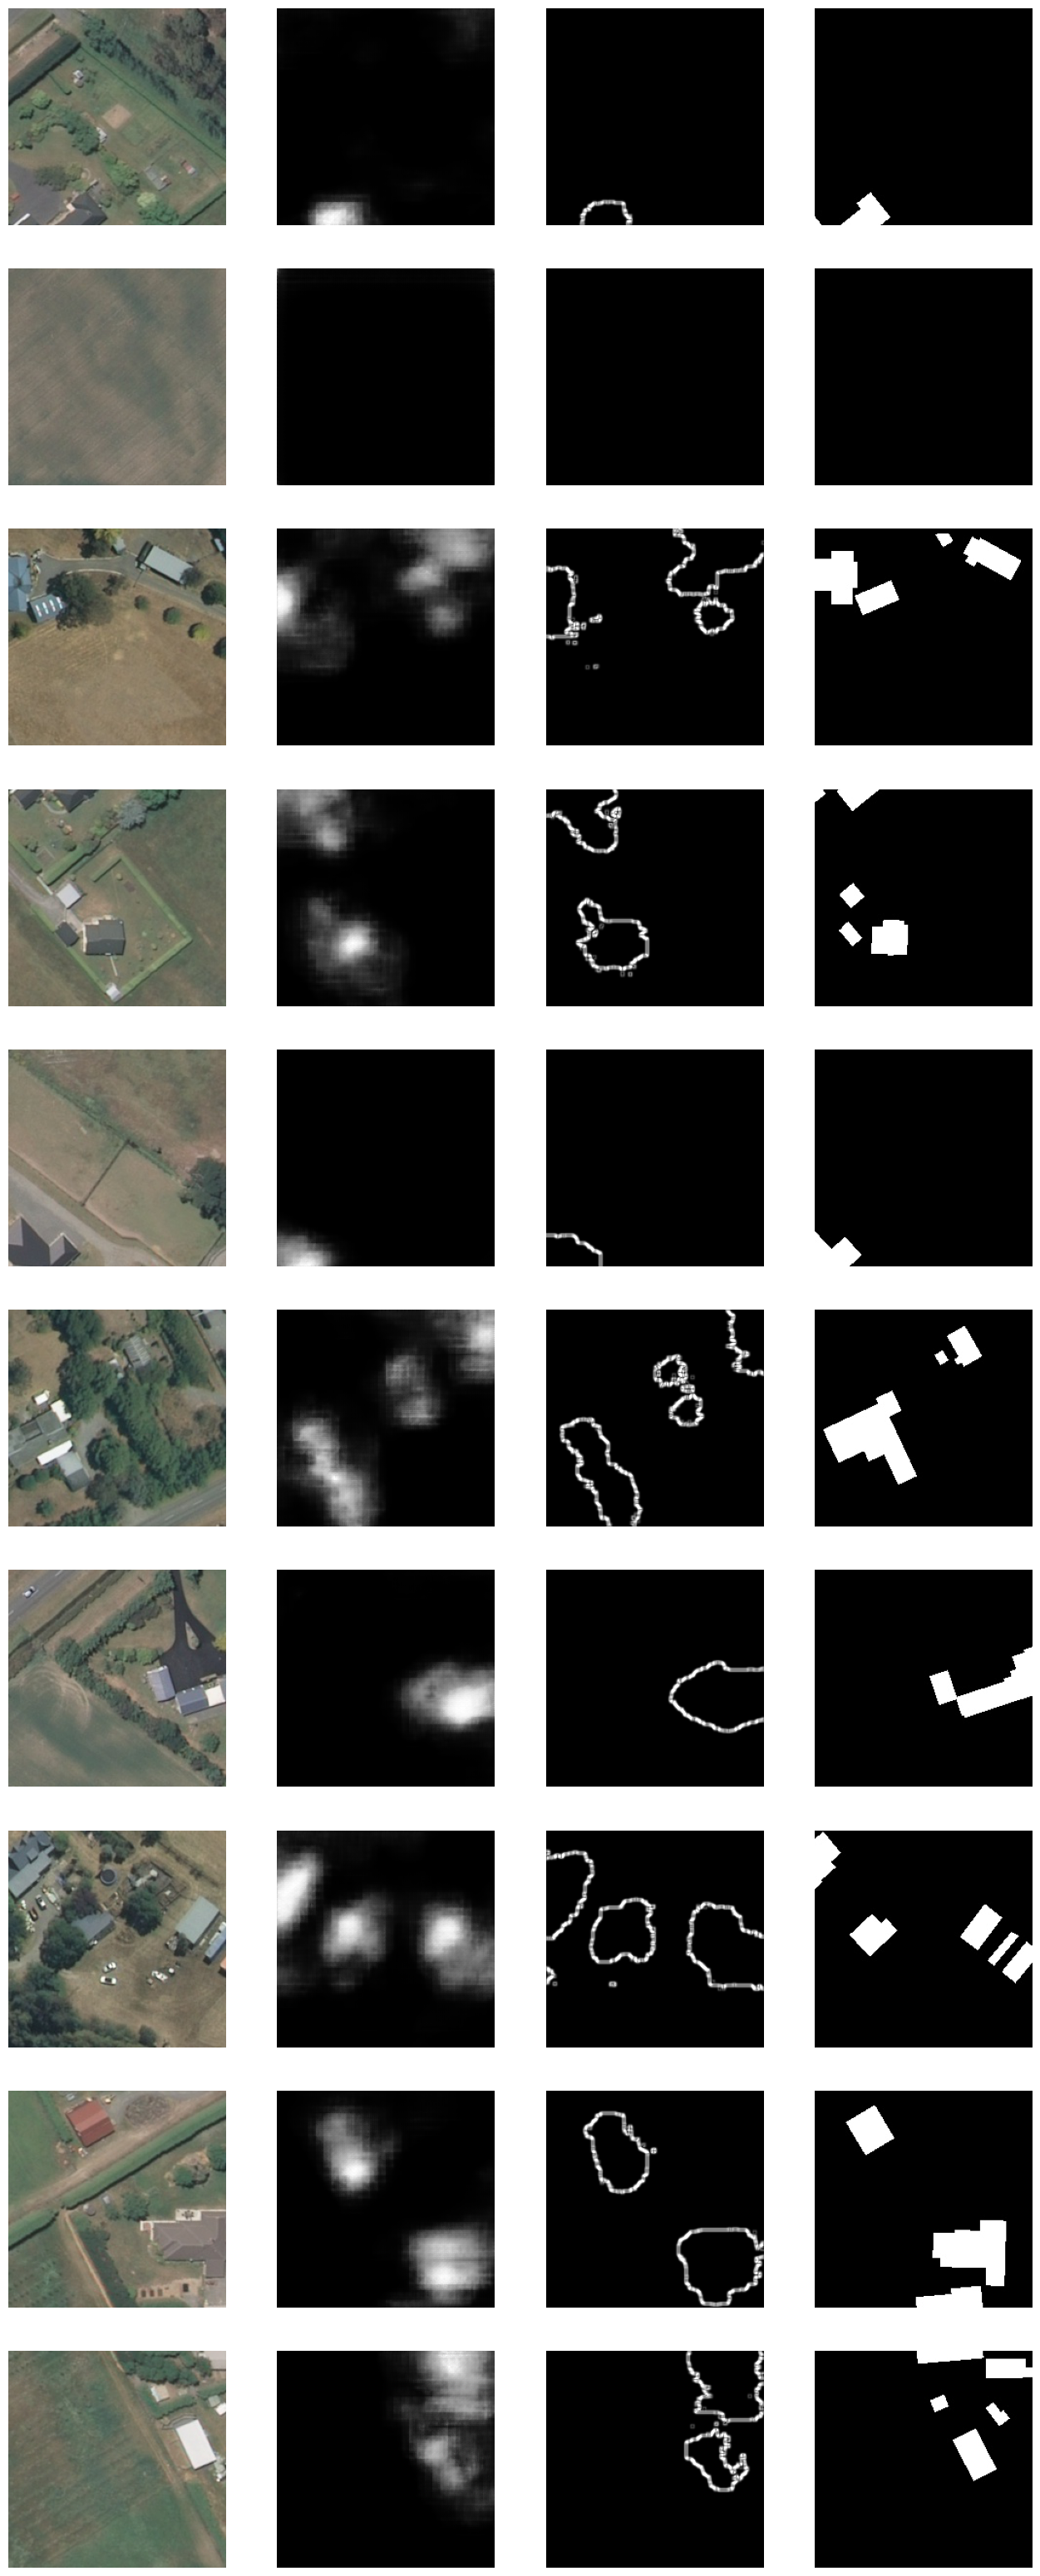

In [49]:
fig, ax = plt.subplots(10, 4, figsize=(16, 40))

for i in range(len(test_preds[:, 0, 0, 0])):

    test_img = test_preds[i, :, :, 0] #some random im
    specific_mask = test_masks[i, :, :, 0]
    specific_sat = X_test[i, :, :]

    thresh_im = (test_img >= mean + std).astype(np.uint8) # applying the upper std thresh

    ddepth=cv2.CV_16S
    # plt.imshow(test_img, cmap='gray')

    grad_x = cv2.Sobel(thresh_im, ddepth, 1, 0, ksize=7) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
    grad_y = cv2.Sobel(thresh_im, ddepth, 0, 1, ksize=7) # This is dy

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

    ax[i][0].imshow(specific_sat)
    ax[i][1].imshow(test_img, cmap='gray')
    ax[i][2].imshow(grad, cmap='gray')
    ax[i][3].imshow(specific_mask, cmap='gray')

    for j in range(0,4):
        ax[i][j].set_axis_off()

plt.show()

This is a great solution to the percentage based approach of having:


$\textbf{building density} = \frac{\textbf{building area}}{\textbf{tile area}}$

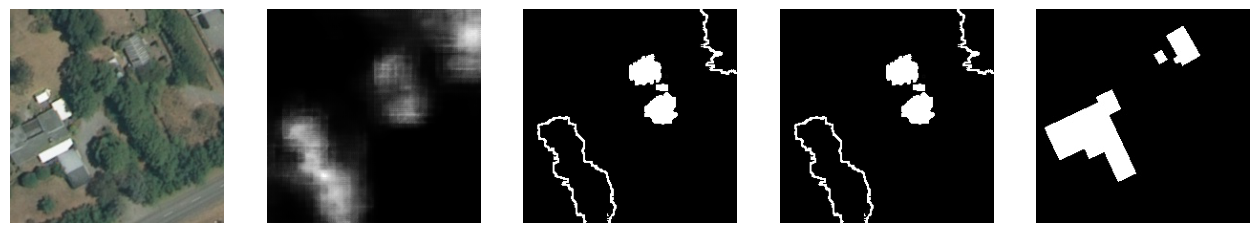

In [73]:
# I will try to use opencv2's fillpoly to "color-in" the outlines:
test_img = test_preds[5, :, :, 0] #some random im
specific_mask = test_masks[5, :, :, 0]
specific_sat = X_test[5, :, :]

ddepth=cv2.CV_16S
# plt.imshow(test_img, cmap='gray')

thresh_im = (test_img >= mean + std).astype(np.uint8) # applying the upper std thresh

grad_x = cv2.Sobel(thresh_im, ddepth, 1, 0, ksize=5) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
grad_y = cv2.Sobel(thresh_im, ddepth, 0, 1, ksize=5) # This is dy

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# scaled = (test_img*255).astype(np.uint8)
filled = cv2.fillPoly(grad, cnts, [255,255,255])

fig, ax = plt.subplots(1, 5, figsize=(16, 14))

ax[0].imshow(specific_sat)
ax[1].imshow(test_img, cmap='gray')
ax[2].imshow(grad, cmap='gray')
ax[3].imshow(filled, cmap='gray')
ax[4].imshow(specific_mask, cmap='gray')

for i in range(len(ax)):
    ax[i].set_axis_off()

plt.show()

In [62]:
len(cnts)

4

In [69]:
cnts = cv2.findContours(grad, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [64]:
n = []

for i in range(len(cnts)):
    filled = cv2.fillPoly(grad, cnts[i], [255,255,255])
    n.append(filled)

np.asarray(n).shape

(4, 224, 224)

In [65]:
n = np.asarray(n)
combined = np.sum(n, axis=0)
combined.shape

(224, 224)

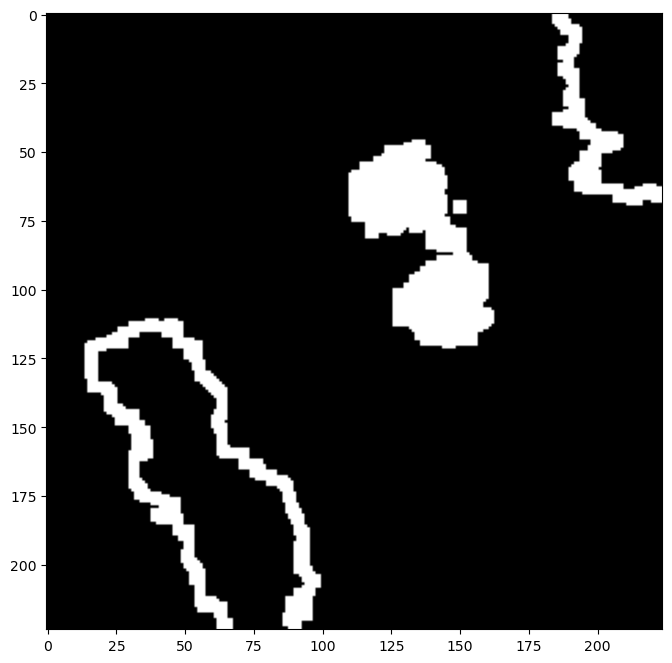

In [68]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.imshow(combined, cmap='gray')

In [ ]:
# TODO: Figure out how to get cv2.fillpoly to work with all the shapes. I think it is probs an issue with how I am getting the outlines atm.
# Maybe I can just directly pass the outlines to fillpoly func and see what happens. Either way this is getting very very close to being great.